# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
# Preparing the dataframe to comply with the machine learning models

label_encoder = LabelEncoder()

label_encoder.fit(df["loan_status"])
df["Loan_Status"] = label_encoder.transform(df["loan_status"])
df.drop(["loan_status"], axis=1, inplace=True)

label_encoder.fit(df["application_type"])
df["Application_Type"] = label_encoder.transform(df["application_type"])
df.drop(["application_type"], axis=1, inplace=True)

label_encoder.fit(df["hardship_flag"])
df["Hardship_Flag"] = label_encoder.transform(df["hardship_flag"])
df.drop(["hardship_flag"], axis=1, inplace=True)

label_encoder.fit(df["debt_settlement_flag"])
df["Debt_Settlement_Flag"] = label_encoder.transform(df["debt_settlement_flag"])
df.drop(["debt_settlement_flag"], axis=1, inplace=True)

label_encoder.fit(df["next_pymnt_d"])
df["Next_Payment_D"] = label_encoder.transform(df["next_pymnt_d"])
df.drop(["next_pymnt_d"], axis=1, inplace=True)

label_encoder.fit(df["pymnt_plan"])
df["Pymnt_Plan"] = label_encoder.transform(df["pymnt_plan"])
df.drop(["pymnt_plan"], axis=1, inplace=True)

label_encoder.fit(df["initial_list_status"])
df["Initial_List_Status"] = label_encoder.transform(df["initial_list_status"])
df.drop(["initial_list_status"], axis=1, inplace=True)

df = pd.get_dummies(df, columns=["home_ownership", "verification_status","issue_d"])
df.head()


,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,0,0,0,1,0,1,0,0,0,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,0,1,0,0,0,0,1,0,0,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,0,1,0,0,0,0,1,0,0,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,0,0,0,1,0,0,1,0,0,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,0,1,0,0,1,0,0,0,0,1


## Split the Data into Training and Testing

In [6]:
x_cols = [i for i in df.columns if i not in ('Loan_Status')]

# Creating our features
X = df[x_cols]

X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.009285,0.526309,0.106747,0.357659,0.478007,0.373992,0.148001,0.371696,0.451066,0.177238
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.095914,0.499311,0.308793,0.479314,0.499520,0.483865,0.355104,0.483261,0.497603,0.381873
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Creating our target
y = df['Loan_Status']
y = y.astype('int')


In [8]:
# Checking the balance of our target values
y.value_counts()

1    68470
0      347
Name: Loan_Status, dtype: int64

In [9]:
# Splitting the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fitting the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [12]:
# Scaling the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resampling the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

y_pred = brf.predict(X_test)

In [14]:
# Calculating the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.767546124350508

In [15]:
# Displaying the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   67,    34],
       [ 2194, 14910]])

In [16]:
# Printing the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.03      0.66      0.87      0.06      0.76      0.57       101
          1       1.00      0.87      0.66      0.93      0.76      0.59     17104

avg / total       0.99      0.87      0.66      0.93      0.76      0.59     17205



In [17]:
# Listing the features sorted in descending order by feature importance
importances = brf.feature_importances_

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

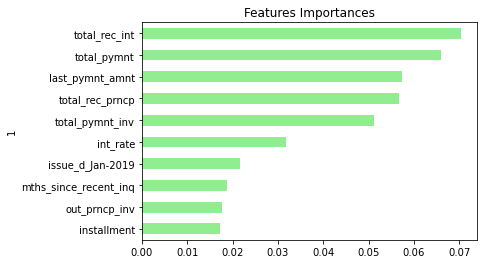

In [18]:
# Visualizing the features by importance
importances_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True)[:10])
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [ ]:
# Print the imbalanced classification report
# YOUR CODE HERE

In [ ]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE

### Easy Ensemble Classifier

In [26]:
# Training the Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [27]:
# Calculating the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.6879726472413378

In [28]:
# Displaying the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   38,    63],
       [    5, 17099]])

In [29]:
# Printing the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.38      1.00      0.53      0.61      0.35       101
          1       1.00      1.00      0.38      1.00      0.61      0.40     17104

avg / total       1.00      1.00      0.38      1.00      0.61      0.40     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    Balanced Random Forest Classifier.

2. Which model had the best recall score?

    Balanaced Random Forest Classifier.

3. Which model had the best geometric mean score?

    Balanced Random Forest Classifier.
    
4. What are the top three features?

    total_rec_int, total_pymnt, and last_pymnt_amnt.